# preamble #

In [459]:
%pip install --user plotly
import plotly.graph_objects as go

Note: you may need to restart the kernel to use updated packages.


['!c', 'a', 'b', 8]
['!b', 'a', 'c', 5]


for a case model to turn into a BN/to freely convert between the two, we need additional structure (how are dependencies between pieces of evidence expressed in a case model? In a BN, this is done through arcs (non-automatic), which is okay. How to specify this in CM?) 

# Testing how case model works #

In [503]:
inputCM = [['!c', 'a', 'b', 8], ['!b', 'a', 'c', 5]]
caseMod = go.Figure()
print(inputCM)
count = 0
sum = 0
for case in inputCM:
    print(count, case)
    case.sort(key=lambda x: x if isinstance(x, str) else "")
    value = case[0]
    case.remove(value)
    case.append(value)
    
    #print(case, value)
    
    #print the case model
    #size = case[len(case)-1]
    caseMod.add_trace(go.Scatter(x=[sum,sum,sum+value,sum+value], y=[0,value,value,0], fill="toself"))
    caseMod.add_trace(go.Scatter(x=[sum + value/2], y=[0.5],text=[case],mode="text"))
    sum = value + sum
    count = count+1

caseMod.show()


TypeError: list indices must be integers or slices, not tuple

In [483]:
evidence = ['a']
iter = 0
for piece in evidence:
    sum = 0
    #caseMod = go.Figure()
    for case in inputCM:
        case.sort(key=lambda x: x if isinstance(x, str) else "")
        value = case[0]
        flag = 0
        for x in case:
            if piece == "".join(["!", str(x)]) or str(x) == "".join(["!", piece]):    #case 1: find a contradiction
                flag = 1
            elif piece == str(x):     #case 2: the evidence is already in the case
                flag = 2
            
        # flag 0 = case 3: the evidence has to be added to the case
        if flag == 0:
            case.append(piece)
        if flag == 1:    # if you find a contradiction, set the size of the case to 0 (or 0.000001 but ugh)
            case.append(piece)
            case[0] = 0
        #if flag == 2:   # if the evidence is already in the case, do nothing
        
        value = case[0]
        caseMod.add_trace(go.Scatter(x=[sum,sum,sum+value,sum+value], y=[0,value,value,0], fill="toself"))
        if flag != 1:
            caseMod.add_trace(go.Scatter(x=[sum + value/2], y=[0.5 + (1+iter)*0.5],text=[case],mode="text"))
        sum = value + sum
        iter = iter + 1
    caseMod.show()

       

# Test case with coffee example: Comparing BN and CM #

In [484]:
from pylab import *
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import os
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn2graph as bng
bn=gum.BayesNet("case")

In [485]:
tired = bn.add(gum.LabelizedVariable('tired','tiredness', 2))
coffee = bn.add(gum.LabelizedVariable('coffee','drink', 2))
bn.addArc(tired, coffee)
bn.cpt(tired).fillWith([0.2,0.8])
bn.cpt(coffee)[{'tired':0}]=[0.8, 0.2]
bn.cpt(coffee)[{'tired':1}]=[0.2, 0.8]



In [486]:
bn
bn.cpt(coffee)
print(bn.cpt(tired)[{}])

[0.2 0.8]


In [487]:
casesInCaseModel = []

for node in bn.nodes():
    print(bn.variable(node).name())
    if str(bn.children(node)) != str(set()): # if the node has children, it is not evidence (fake)
        name = bn.variable(node).name()
        prior = bn.cpt(name)[{}]
        print(prior)
        casesInCaseModel.append([prior[1], name])
        casesInCaseModel.append([prior[0], "!"+name])   # this is a hack but works for binary outcomes
casesInCaseModel

tired
[0.2 0.8]
coffee


[[0.8, 'tired'], [0.2, '!tired']]

In [488]:
for case in casesInCaseModel:
    print(case)

[0.8, 'tired']
[0.2, '!tired']


In [489]:
caseModTest = go.Figure()
print(casesInCaseModel)
count = 0
sum = 0
for case in casesInCaseModel:
    print(count, case)
    case.sort(key=lambda x: x if isinstance(x, str) else "")
    value = case[0]
    case.remove(value)
    case.append(value)
    #print(case, value)
    #print the case model
    size = case[len(case)-1]
    caseModTest.add_trace(go.Scatter(x=[sum,sum,sum+value,sum+value], y=[0,1,1,0], fill="toself"))
    caseModTest.add_trace(go.Scatter(x=[sum + value/2], y=[0.05],text=[case],mode="text"))
    sum = value + sum
    count = count+1

caseModTest.show()
bn
casesInCaseModel



[[0.8, 'tired'], [0.2, '!tired']]
0 [0.8, 'tired']
1 [0.2, '!tired']


[['tired', 0.8], ['!tired', 0.2]]

The first step is now completed: the first hypotheses (for now: the only nodes without parents) have been assigned a case: there's a case for tired, and a case for not tired.

Now, I want to 'assign priors'. This is not the same as adding evidence (switching on the evidence node in the BN), but it's drawing how a potential piece of evidence would affect the CM. This is the bn.cpt(coffee) step.

so, for tired, i want (tired, coffee), (tired, !coffee), and for not tired I want the same.

In [490]:
for case in casesInCaseModel:
    print(case)

['tired', 0.8]
['!tired', 0.2]


In [491]:
bn
bn.cpt(coffee)
print(bn.cpt(tired)[{}])


print(casesInCaseModel)
newListofLists = []
for case in casesInCaseModel:
    listA = []
    listB = []
    name = case[0] #hacky
    #print(name)
    if name[0] != '!':
        x = bn.variable(name).name()
        nameFlag = 1
    else:
        x = bn.variable(name[1:]).name()
        nameFlag = 0
    #print(x)
    bn.children(x)   # for tired, we now have a set of children
    # we want to split the list so we get two cases
    for child in bn.children(x):
        listA = []
        listB = []
        nameChild = bn.variable(child).name()
        valsTrue = bn.cpt(child)[{x:1}][0]
        valsFalse = bn.cpt(child)[{x:0}][0]
        listA = case.copy()
        listB = case.copy()
        listA.insert(1, nameChild)
        listB.insert(1,"!"+nameChild)
        if nameFlag == 1:
            listA[len(listA)-1] = [case[len(case)-1], valsFalse]    #ugly
            listB[len(listB)-1] = [case[len(case)-1], valsTrue]
        if nameFlag == 0:
            listA[len(listA)-1] = [case[len(case)-1], valsTrue]    #ugly
            listB[len(listB)-1] = [case[len(case)-1], valsFalse]
    newListofLists.append(listA)
    newListofLists.append(listB)
    
for items in newListofLists:
    casesInCaseModel.append(items)
for cases in casesInCaseModel:
    print(cases)



[0.2 0.8]
[['tired', 0.8], ['!tired', 0.2]]
['tired', 0.8]
['!tired', 0.2]
['tired', 'coffee', [0.8, 0.8]]
['tired', '!coffee', [0.8, 0.2]]
['!tired', 'coffee', [0.2, 0.2]]
['!tired', '!coffee', [0.2, 0.8]]


Now to visualize the thing. We don't want to change the x-values

In [492]:
caseModTest = go.Figure()

In [493]:
print(casesInCaseModel)
count = 0
sum = 0
valYA = 0
valYB = 0
for case in casesInCaseModel:
    print(count, case)
    hyp = case[0]
    print(case[0])
    case.sort(key=lambda x: x if isinstance(x, str) else "")
    value = case[0]
    print(value)
    case.remove(value)
    case.append(value)
    #print(case, value)
    #print the case model
    size = case[len(case)-1]
    if type(value) == list:#only want to print the new additions!
        if case.count("tired") >0:    #HACK BAD
            caseModTest.add_trace(go.Scatter(x=[0,0,value[0],value[0]], y=[valYA,valYA+value[1],valYA+value[1],valYA], fill="toself"))
            caseModTest.add_trace(go.Scatter(x=[0 + value[0]/2], y=[valYA+value[1]/2],text=[case],mode="text"))
            valYA = valYA + value[1]
        if case.count("!tired") >0:    #HACK BAD
            caseModTest.add_trace(go.Scatter(x=[1-value[0],1-value[0],1,1], y=[valYB,valYB+value[1],valYB+value[1],valYB], fill="toself"))
            caseModTest.add_trace(go.Scatter(x=[1-value[0]/2], y=[valYB+value[1]/2],text=[case],mode="text"))
            valYB = valYB + value[1]
    #if name = prevName
    #    sum = value + sum
    count = count+1

caseModTest.show()

#casesInCaseModel

[['tired', 0.8], ['!tired', 0.2], ['tired', 'coffee', [0.8, 0.8]], ['tired', '!coffee', [0.8, 0.2]], ['!tired', 'coffee', [0.2, 0.2]], ['!tired', '!coffee', [0.2, 0.8]]]
0 ['tired', 0.8]
tired
0.8
1 ['!tired', 0.2]
!tired
0.2
2 ['tired', 'coffee', [0.8, 0.8]]
tired
[0.8, 0.8]
3 ['tired', '!coffee', [0.8, 0.2]]
tired
[0.8, 0.2]
4 ['!tired', 'coffee', [0.2, 0.2]]
!tired
[0.2, 0.2]
5 ['!tired', '!coffee', [0.2, 0.8]]
!tired
[0.2, 0.8]


And then, the updating on evidence. With the BN, this is done using some tool, lazypropagation, when the evidence is set

In [494]:
ie= gum.LazyPropagation(bn)
ie.posterior(tired)

(gum::Potential<double>@0x7fc9e4fa9bf0) <tired:0> :: 0.2 /<tired:1> :: 0.8

In [495]:
ie.setEvidence({'coffee':0})
ie.posterior(tired)

(gum::Potential<double>@0x7fc9e4fa9a70) <tired:0> :: 0.5 /<tired:1> :: 0.5

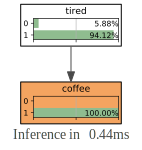

In [500]:
gnb.showInference(bn,evs={'coffee':1})

To translate this to the case model, we first need to translate {coffee:0} to !coffee. Once that is done, we can go through the evidence loop.

In [501]:
evidence = ['coffee'] # TODO: automatic updating between the two

iter = 0
for piece in evidence:
    caseModTest = go.Figure()
    sum = 0
    valYA =0
    valYB = 0
    #caseMod = go.Figure()
    for case in casesInCaseModel:
        case.sort(key=lambda x: x if isinstance(x, str) else "")
        value = case[0]
        flag = 0
        for x in case:
            if piece == "".join(["!", str(x)]) or str(x) == "".join(["!", piece]):    #case 1: find a contradiction
                flag = 1
            elif piece == str(x):     #case 2: the evidence is already in the case
                flag = 2
            
        # flag 0 = case 3: the evidence has to be added to the case
        if flag == 0:
            case.append(piece)
        if flag == 1:    # if you find a contradiction, set the size of the case to 0 (or 0.000001 but ugh)
            case.append(piece)
            case[0] = 0
        #if flag == 2:   # if the evidence is already in the case, do nothing
        value = case[0]
        if type(value) == list:
            if case.count("tired") >0:    #HACK BAD
                caseModTest.add_trace(go.Scatter(x=[0,0,value[0],value[0]], y=[0,valYA+value[1],valYA+value[1],0], fill="toself"))
                caseModTest.add_trace(go.Scatter(x=[0 + value[0]/2], y=[valYA+value[1]/2],text=[case],mode="text"))
                valYA = valYA + value[1]
            if case.count("!tired") >0:    #HACK BAD
                caseModTest.add_trace(go.Scatter(x=[1-value[0],1-value[0],1,1], y=[0,valYB+value[1],valYB+value[1],0], fill="toself"))
                caseModTest.add_trace(go.Scatter(x=[1-value[0]/2], y=[valYB+value[1]/2],text=[case],mode="text"))
                valYB = valYB + value[1]
            
caseModTest.show()        
casesInCaseModel
       


[[0.8, 'coffee', 'tired'],
 [0.2, '!tired', 'coffee'],
 [[0.8, 0.8], 'coffee', 'tired'],
 [0, '!coffee', 'coffee', 'tired'],
 [[0.2, 0.2], '!tired', 'coffee'],
 [0, '!coffee', '!tired', 'coffee']]

So, to compare the two final situations after one update on '!coffee'

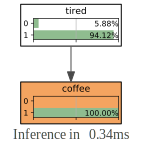

In [502]:
caseModTest.show() 
gnb.showInference(bn,evs={'coffee':1})

In ratios: area of COFFEE&TIRED = 64%, COFFEE&!TIRED = 4%, rest 32%. Not the same as conditional/bayesian values, but preference ordering is clear between two cases with evidence.

TODO: 
- richer format in order to distinguish *hyp* from *evidence*
- more than one child?
- how to know which hypothesis a case belongs to?
- are hypotheses even real?